In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import torch
import transformers
from transformers import BertForTokenClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup

!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange
import torch.optim as optim
from seqeval.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

MAX_LEN = 75
bs = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

transformers.__version__
torch.__version__

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=7267a59b9b393a46efca51c1cae101805a8ba06bfead44ef27962abf12783ecb
  Stored in directory: /root/.cache/pip/wheels/b2/a1/b7/0d3b008d0c77cd57332d724b92cf7650b4185b493dc785f00a
Successfully built seqeval


In [2]:
train = pd.read_csv("/kaggle/input/voc-processed-data/train-nl.tsv", sep="\t")
len(train)

359695

In [34]:
train.head()

,DOC PATH,TOKEN,NE-MAIN,NE-PER-NAME,NE-PER-GENDER,NE-PER-LEGAL-STATUS,NE-PER-ROLE,NE-ORG-BENEFICIARY,MISC
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,# language = nl,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,# document_path = ../data/annotated_data/A/NL-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,heste,O,O,O,O,O,O,_
4,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,afschrift,O,O,O,O,O,O,_


In [4]:
train['NE-MAIN'].value_counts()

O                                  321262
I-Person                            15444
B-Person                             8216
I-Place                              3766
B-Place                              2856
I-Organization                       2155
B-Organization                        741
I-Organization,B-Place                208
I-Organization,I-Place                111
I-Person,B-Place                      105
I-Person,I-Place                       54
B-Organization,I-Place                 25
B-Person,I-Place                       19
I-Organization,I-Person                 4
B-Organization,B-Place                  2
B-Person,B-Place                        2
B-Organization,I-Person                 1
I-Organization,I-Person,B-Place         1
I-Organization,I-Person,I-Place         1
Name: NE-MAIN, dtype: int64

In [5]:
df = train
df['DOC PATH'] = df['TOKEN'].str.extract(r'# document_path = (.*)', expand=False).ffill()

In [6]:
# Move Sentence # to the front
sentence_col = df.pop('DOC PATH')
df.insert(0, 'DOC PATH', sentence_col)

df = df.dropna()
print(df.isnull().sum())
# df = df.dropna(subset=["NE-MAIN"])
# df = df.dropna(subset=["TOKEN"])

df.head()

DOC PATH               0
TOKEN                  0
NE-MAIN                0
NE-PER-NAME            0
NE-PER-GENDER          0
NE-PER-LEGAL-STATUS    0
NE-PER-ROLE            0
NE-ORG-BENEFICIARY     0
MISC                   0
dtype: int64


,DOC PATH,TOKEN,NE-MAIN,NE-PER-NAME,NE-PER-GENDER,NE-PER-LEGAL-STATUS,NE-PER-ROLE,NE-ORG-BENEFICIARY,MISC
3,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,heste,O,O,O,O,O,O,_
4,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,afschrift,O,O,O,O,O,O,_
5,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,m,O,O,O,O,O,O,_
6,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,In,O,O,O,O,O,O,_
7,../data/annotated_data/A/NL-HaNA_1.04.02_6857_...,den,O,O,O,O,O,O,_


In [ ]:
# df[(df != 'O').all(axis=1)]

In [ ]:
# df[(df.iloc[:, :-3] != 'O').all(axis=1)]

In [7]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["TOKEN"].values.tolist(),
                                                     s["NE-MAIN"].values.tolist())]
        self.grouped = self.data.groupby("DOC PATH").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(df)

In [9]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['11',
 '„',
 '„',
 '35',
 'in',
 'beneven',
 'zijn',
 'Gemelde',
 'aanbehumde',
 'vader',
 'de',
 'voorneemde',
 '_',
 '5',
 'tames',
 'va',
 'e2',
 '25',
 '6',
 'welken',
 'hy',
 'testateur',
 'betuigde',
 'in',
 'dienst',
 'aangenemen',
 'en',
 'uitgevaren',
 'te',
 'zyn',
 'ten',
 'Eynde',
 'door',
 'haar',
 'hoog',
 'Edele',
 'groot',
 'agtb=r',
 'uytgekeerd',
 'te',
 'werden',
 'aan',
 'de',
 'geene',
 'da',
 'tot',
 'dies',
 'ontfangst',
 'zal',
 'ef',
 'zullen',
 'Wesen',
 'gequalificeerd',
 'Behuygende',
 'den',
 'toetateur',
 'op',
 'myne',
 'gedane',
 'verage',
 'dat',
 'zyn',
 'beidel',
 'beneden',
 'de',
 'Twee',
 'duivend',
 'rd:s',
 'was',
 'bedragen',
 'de',
 'voorts',
 'heb',
 'ik',
 'Not:s',
 'den',
 'Poetaleur',
 'behoorlyk',
 "g'informeerd",
 'van',
 'de',
 'Jongste',
 'besluyten',
 'door',
 'welmelde',
 'hunne',
 'hoog',
 'Edelhedens',
 'ten',
 'op„',
 'Bigt',
 'van',
 'de',
 'Lijsteygenen',
 'die',
 'gedoopt',
 'in',
 'de',
 'christelyke',
 'leere',
 'onderwesen',

The sentences are annotated with the BIO-schema and the labels look like this.

In [10]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Person', 'I-Person', 'I-Person', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Person', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Place', 'I-Place', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-P

In [11]:
tag_values = list(set(df["NE-MAIN"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [12]:
tag2idx

{'B-Person': 0,
 'B-Organization,I-Place': 1,
 'I-Organization,I-Place': 2,
 'O': 3,
 'I-Organization,B-Place': 4,
 'B-Person,I-Place': 5,
 'I-Person,B-Place': 6,
 'B-Organization': 7,
 'I-Organization': 8,
 'B-Organization,B-Place': 9,
 'I-Person': 10,
 'I-Organization,I-Person,I-Place': 11,
 'I-Person,I-Place': 12,
 'B-Person,B-Place': 13,
 'B-Organization,I-Person': 14,
 'I-Place': 15,
 'B-Place': 16,
 'I-Organization,I-Person': 17,
 'I-Organization,I-Person,B-Place': 18,
 'PAD': 19}

In [13]:
def get_tag_distribution(df, tag_col):
    tag_distribution = df.groupby(tag_col).size().reset_index(name='counts')
    tag_distribution = tag_distribution.sort_values('counts', ascending=False)
    tag_distribution['percentage'] = (tag_distribution['counts'] / tag_distribution['counts'].sum()) * 100
    return tag_distribution

In [14]:
columns = ['NE-MAIN', 'NE-PER-NAME', 'NE-PER-GENDER', 'NE-PER-LEGAL-STATUS', 'NE-PER-ROLE', 'NE-ORG-BENEFICIARY', 'MISC']
for col in columns:
    print(f"Tag distribution for {col}:")
    print(get_tag_distribution(df, col))
    print()

Tag distribution for NE-MAIN:
                            NE-MAIN  counts  percentage
18                                O  321259   90.503141
14                         I-Person   15444    4.350790
4                          B-Person    8216    2.314562
17                          I-Place    3766    1.060935
7                           B-Place    2856    0.804575
8                    I-Organization    2155    0.607094
0                    B-Organization     741    0.208750
9            I-Organization,B-Place     208    0.058597
13           I-Organization,I-Place     111    0.031270
15                 I-Person,B-Place     105    0.029580
16                 I-Person,I-Place      54    0.015213
3            B-Organization,I-Place      25    0.007043
6                  B-Person,I-Place      19    0.005353
10          I-Organization,I-Person       4    0.001127
5                  B-Person,B-Place       2    0.000563
1            B-Organization,B-Place       2    0.000563
11  I-Organization

In [15]:
classes = list(filter(lambda x: x not in ["O", np.nan], list(df["NE-MAIN"].unique())))
print(classes)

['B-Person', 'I-Person', 'B-Place', 'I-Place', 'B-Organization', 'I-Organization', 'I-Person,B-Place', 'I-Person,I-Place', 'I-Organization,B-Place', 'I-Organization,I-Place', 'B-Organization,I-Place', 'B-Organization,I-Person', 'I-Organization,I-Person', 'I-Organization,I-Person,B-Place', 'I-Organization,I-Person,I-Place', 'B-Organization,B-Place', 'B-Person,I-Place', 'B-Person,B-Place']


In [16]:
tokenizer = BertTokenizer.from_pretrained('GroNLP/bert-base-dutch-cased', do_lower_case=False) #bert-base-cased

In [17]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [18]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [19]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [20]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [21]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [22]:
label_counts = np.unique(tags, return_counts=True)
print(label_counts) # Data is imbalanced

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17,
       18, 19]), array([ 3685,    14,    62, 98552,    88,     2,    88,   296,   774,
           7,  7698,     1,     9,     1,  1667,  1295,     9,     2,
        3800]))


In [23]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [24]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [25]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [26]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [27]:
model = BertForTokenClassification.from_pretrained(
    "GroNLP/bert-base-dutch-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased

In [28]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = optim.AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [29]:
epochs = 7
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [30]:
valid_seq_lens = []
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    seq_lens = b_input_mask.sum(dim=1).tolist()
    valid_seq_lens.extend(seq_lens)

In [31]:
def nested_list(lst, seq_lens):
    nested = []
    i = 0
    for seq_len in seq_lens:
        nested.append(lst[i:i+seq_len])
        i += seq_len
    return nested

In [32]:
valid_seq_lens = [int(x) for x in valid_seq_lens]

In [39]:
loss_values, validation_loss_values = [], []
# precision_values = []
# recall_values = []

for _ in trange(epochs, desc="Epoch"):
    model.train()
    total_loss = 0
    total_precision = 0
    total_recall = 0
    total_samples = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        
#         logits = outputs[1]
#         preds = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()
        
        # calculate precision and recall
#         preds_flat = np.argmax(preds, axis=2).flatten()
#         labels_flat = label_ids.flatten()
#         precision = precision_score(labels_flat, preds_flat, average='weighted', zero_division=0)
#         recall = recall_score(labels_flat, preds_flat, average='weighted', zero_division=0)
#         total_precision += precision * len(labels_flat)
#         total_recall += recall * len(labels_flat)
#         total_samples += len(labels_flat)
        
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    loss_values.append(avg_train_loss)
    
#     avg_train_precision = total_precision / total_samples
#     print("Average train precision: {}".format(avg_train_precision))
#     precision_values.append(avg_train_precision)
    
#     avg_train_recall = total_recall / total_samples
#     print("Average train recall: {}".format(avg_train_recall))
#     recall_values.append(avg_train_recall)
    
#     == EVAL ==
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    for p, l in zip(predictions, true_labels):
        for p_i, l_i in zip(p, l):
            if tag_values[l_i] != "PAD" and l_i >= len(tag_values):
                print("Problematic index:", l_i)
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    
    pred_tags_nested = nested_list(pred_tags,valid_seq_lens)
    valid_tags_nested = nested_list(valid_tags,valid_seq_lens)
#     print("Validation F1-Score: {}".format(f1_score(pred_tags_nested, valid_tags_nested)))
    
    report = classification_report(valid_tags_nested, pred_tags_nested, digits=4)
    print(report)
    
    print()

Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

Average train loss: 0.21790692971812353
Validation loss: 0.2544423997402191
Validation Accuracy: 0.9227899713715624


Epoch:  14%|█▍        | 1/7 [08:59<53:59, 539.86s/it]

                      precision    recall  f1-score   support

                  AD     0.0000    0.0000    0.0000         0
        Organization     0.0000    0.0000    0.0000        27
Organization,B-Place     0.0000    0.0000    0.0000         9
Organization,I-Place     0.0000    0.0000    0.0000         7
              Person     0.5123    0.4987    0.5054       377
      Person,B-Place     0.0000    0.0000    0.0000         1
               Place     0.2212    0.1969    0.2083       127

           micro avg     0.4392    0.3887    0.4124       548
           macro avg     0.1048    0.0994    0.1020       548
        weighted avg     0.4037    0.3887    0.3960       548


Average train loss: 0.15630132589075302
Validation loss: 0.23871806859970093
Validation Accuracy: 0.9312917498048061


Epoch:  29%|██▊       | 2/7 [18:03<45:09, 541.84s/it]

                      precision    recall  f1-score   support

                  AD     0.0000    0.0000    0.0000         0
        Organization     0.1600    0.1481    0.1538        27
Organization,B-Place     0.2500    0.1111    0.1538         9
Organization,I-Place     0.0000    0.0000    0.0000         7
              Person     0.5615    0.5332    0.5469       377
      Person,B-Place     0.0000    0.0000    0.0000         1
               Place     0.3000    0.2598    0.2785       127

           micro avg     0.4761    0.4361    0.4552       548
           macro avg     0.1816    0.1503    0.1619       548
        weighted avg     0.4678    0.4361    0.4509       548


Average train loss: 0.12153097341458002
Validation loss: 0.25725379288196565
Validation Accuracy: 0.9331135594690726


Epoch:  43%|████▎     | 3/7 [27:03<36:05, 541.28s/it]

                      precision    recall  f1-score   support

                  AD     0.0000    0.0000    0.0000         0
        Organization     0.1905    0.1481    0.1667        27
Organization,B-Place     0.0000    0.0000    0.0000         9
Organization,I-Place     0.0000    0.0000    0.0000         7
              Person     0.5741    0.5650    0.5695       377
      Person,B-Place     0.0000    0.0000    0.0000         1
               Place     0.4153    0.3858    0.4000       127

           micro avg     0.5145    0.4854    0.4995       548
           macro avg     0.1686    0.1570    0.1623       548
        weighted avg     0.5006    0.4854    0.4927       548


Average train loss: 0.098581273191505
Validation loss: 0.26025698482990267
Validation Accuracy: 0.9324195367398282


Epoch:  57%|█████▋    | 4/7 [36:06<27:05, 541.91s/it]

                      precision    recall  f1-score   support

                  AD     0.0000    0.0000    0.0000         0
        Organization     0.1905    0.1481    0.1667        27
Organization,B-Place     0.1667    0.1111    0.1333         9
Organization,I-Place     0.0000    0.0000    0.0000         7
              Person     0.5695    0.5650    0.5672       377
      Person,B-Place     0.0000    0.0000    0.0000         1
               Place     0.3280    0.3228    0.3254       127

           micro avg     0.4905    0.4726    0.4814       548
           macro avg     0.1792    0.1639    0.1704       548
        weighted avg     0.4799    0.4726    0.4761       548


Average train loss: 0.08039576999015279
Validation loss: 0.2896289020776749
Validation Accuracy: 0.9319857725340505


Epoch:  71%|███████▏  | 5/7 [45:03<17:59, 539.99s/it]

                      precision    recall  f1-score   support

                  AD     0.0000    0.0000    0.0000         0
        Organization     0.1875    0.1111    0.1395        27
Organization,B-Place     0.2500    0.1111    0.1538         9
Organization,I-Place     0.0000    0.0000    0.0000         7
              Person     0.5508    0.5756    0.5629       377
      Person,B-Place     0.0000    0.0000    0.0000         1
               Place     0.3946    0.4567    0.4234       127

           micro avg     0.4947    0.5091    0.5018       548
           macro avg     0.1975    0.1792    0.1828       548
        weighted avg     0.4837    0.5091    0.4948       548


Average train loss: 0.06952063085304366
Validation loss: 0.29455991089344025
Validation Accuracy: 0.9342413464040947


Epoch:  86%|████████▌ | 6/7 [54:00<08:59, 539.17s/it]

                      precision    recall  f1-score   support

                  AD     0.0000    0.0000    0.0000         0
        Organization     0.1905    0.1481    0.1667        27
Organization,B-Place     0.1429    0.1111    0.1250         9
Organization,I-Place     0.0000    0.0000    0.0000         7
              Person     0.5831    0.5491    0.5656       377
      Person,B-Place     0.0000    0.0000    0.0000         1
               Place     0.4118    0.4409    0.4259       127

           micro avg     0.5134    0.4891    0.5009       548
           macro avg     0.1897    0.1785    0.1833       548
        weighted avg     0.5083    0.4891    0.4980       548


Average train loss: 0.06077540305753549
Validation loss: 0.29631911814212797
Validation Accuracy: 0.9337208293571615


Epoch: 100%|██████████| 7/7 [1:02:57<00:00, 539.64s/it]

                      precision    recall  f1-score   support

                  AD     0.0000    0.0000    0.0000         0
        Organization     0.2069    0.2222    0.2143        27
Organization,B-Place     0.1429    0.1111    0.1250         9
Organization,I-Place     0.0000    0.0000    0.0000         7
              Person     0.5886    0.5729    0.5806       377
      Person,B-Place     0.0000    0.0000    0.0000         1
               Place     0.4414    0.5039    0.4706       127

           micro avg     0.5218    0.5237    0.5228       548
           macro avg     0.1971    0.2015    0.1986       548
        weighted avg     0.5197    0.5237    0.5211       548




<AxesSubplot:>

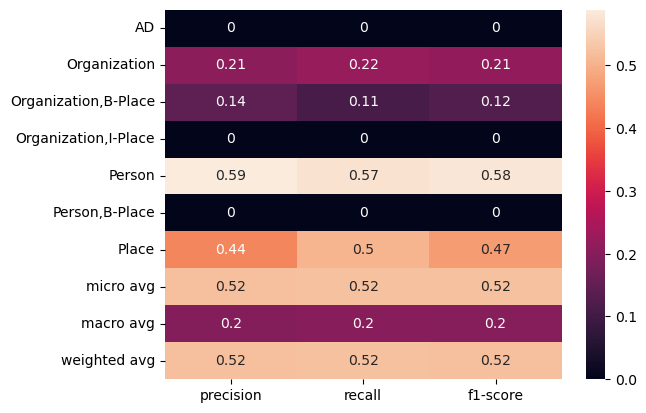

In [47]:
report_ = classification_report(valid_tags_nested, pred_tags_nested, digits=4,output_dict=True)
sns.heatmap(pd.DataFrame(report_).iloc[:-1, :].T, annot=True)

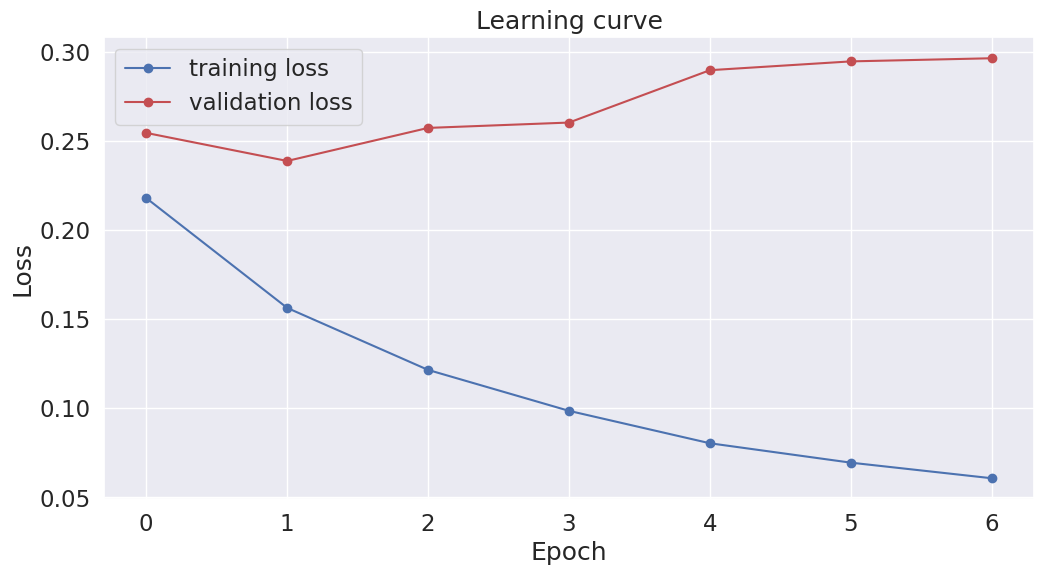

In [48]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
# extract precision, recall, and f1-score for each class
precision = [report[class_name]['precision'] for class_name in classes]
recall = [report[class_name]['recall'] for class_name in classes]
f1_score = [report[class_name]['f1-score'] for class_name in classes]

# plot the scores
fig, ax = plt.subplots()
x = np.arange(len(classes))
width = 0.2
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1_score, width, label='F1-score')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
plt.show()